In [1]:
%matplotlib inline
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import plotly.graph_objects as go
from typing import Dict, Any, Optional
import plotly.express as px
import ast

plt.style.use("../plt_plot_style.mplstyle")
f_name = "../project.csv"
raw_df = pd.read_csv(f_name)
raw_df.head()
# df = pd.read_csv("../processed_results.csv", index_col="id")

,Unnamed: 0,summary,config,name,id,state,sweep_id
0,0,{'z-block1.layer.2.conv2-Fan-Ins': {'values': ...,"{'rigl': {'alpha': 0.3, 'delta': 100, 'use_t_e...",wide_resnet22_cifar10_dense_alloc-0.5_const_fa...,it4iufi7,running,uw4nrruy
1,1,{'z-block2.layer.1.conv2-Max-Inactive_Weight':...,"{'rigl': {'alpha': 0.3, 'delta': 100, 'use_t_e...",wide_resnet22_cifar10_dense_alloc-0.5_const_fa...,cqlgrosj,running,uw4nrruy
2,2,{'z-block2.layer.0.conv1-Max-Inactive_Grad': 0...,"{'rigl': {'alpha': 0.3, 'delta': 100, 'use_t_e...",wide_resnet22_cifar10_dense_alloc-0.5_const_fa...,rf2ti8y9,running,uw4nrruy
3,3,{'z-block1.layer.2.conv1-Fan-Ins': {'_type': '...,"{'rigl': {'alpha': 0.3, 'delta': 100, 'use_t_e...",wide_resnet22_cifar10_dense_alloc-0.5_const_fa...,ugy853s1,running,uw4nrruy
4,4,{'z-block2.layer.0.convShortcut-Max-Weight-Per...,"{'rigl': {'alpha': 0.3, 'delta': 100, 'use_t_e...",wide_resnet22_cifar10_dense_alloc-0.4_const_fa...,gcsk8ltv,running,uw4nrruy


In [2]:
def parse_wandb_results(project_results_csv: str) -> pd.DataFrame:
    df = pd.read_csv(project_results_csv)
    df = df.set_index("id")
    config_df = df["config"].apply(lambda x: pd.json_normalize(ast.literal_eval(x)))
    config_df = pd.concat(config_df.to_dict())
    config_df.index = df.index
    summary_df = df["summary"].apply(lambda x: pd.json_normalize(ast.literal_eval(x)))
    summary_df = pd.concat(summary_df.to_dict())
    summary_df.index = df.index
    combined_df = pd.concat([df, config_df, summary_df,], axis=1)
    sorted_cols = sorted(combined_df.columns)
    combined_df = combined_df[sorted_cols]
    combined_df.to_csv("../processed_results.csv")
    return combined_df

# df = parse_wandb_results("../project.csv")
df = pd.read_csv("../processed_results.csv", index_col="id")

/tmp/ipykernel_276103/1414717271.py:17: DtypeWarning: Columns (14,15,16,19,20,21,22,23,27,28,29,31,33,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,2

In [4]:
def model_state_filter(df, epoch=250):
    return df.loc[(df["state"]=="finished") & (df["epoch"]==epoch)]

def display_group_by(df, groupby_vars, sort_by = "accuracy"):
    return df.groupby(groupby_vars).mean().sort_values(by=sort_by, ascending=False)[sort_by]

def get_model_name_filter(df, model_name):
    return df.loc[((df['model.name']==model_name) | (df['model']==model_name))] 

def get_sparse_grad_flow(df):
    return df.loc[df["rigl.init_method_str"] == "grad_flow_init"]

def get_sparse_saliency(df):
    return df[df["name"].str.contains("salients_only")]

def get_model_results(df, model_name="resnet18", expected_epochs=250):
    model_df = model_state_filter(df, expected_epochs)
    model_df = get_model_name_filter(model_df, model_name)
    # model_df = get_sparse_grad_flow(model_df)
    # model_df = get_sparse_saliency(model_df)
    return model_df


resnet18=get_model_results(df, "resnet18", 250)
wide_resnet22=get_model_results(df, "wide_resnet22", 250)
imagenet=get_model_results(df, "resnet50", 103)
# imagenet = imagenet.loc[imagenet["sweep_id"]=="aw7o7hz7"]

In [12]:
imagenet.loc[imagenet["rigl.const_fan_in"]==True][["rigl.dynamic_ablation", "rigl.dense_allocation"]]

,rigl.dynamic_ablation,rigl.dense_allocation
id,,
tbd2s4n5,True,0.20
pwj6hktu,True,0.10
51tgdkfn,True,0.05
oqqccm3r,True,0.01
3rk8eon8,True,0.01
19ucwmac,True,0.01
32azlq05,True,0.01
3e8pmjn5,True,0.01
1ipb7zrv,True,0.01


In [9]:
display_group_by(imagenet, groupby_vars=["rigl.const_fan_in", "rigl.dense_allocation"])

rigl.const_fan_in  rigl.dense_allocation
False              0.20                     0.74878
True               0.20                     0.74720
                   0.10                     0.73050
False              0.10                     0.72756
                   0.05                     0.69662
True               0.05                     0.68962
False              0.01                     0.51354
True               0.01                     0.50540
Name: accuracy, dtype: float64

In [10]:
imagenet.groupby(["rigl.const_fan_in", "rigl.dense_allocation"]).count()

ITOP Rate  Learning Rate  \
rigl.const_fan_in rigl.dense_allocation                             
False             0.01                           1              1   
                  0.05                           1              1   
                  0.10                           1              1   
                  0.20                           1              1   
True              0.01                           1              1   
                  0.05                           1              1   
                  0.10                           1              1   
                  0.20                           1              1   

                                         Training Loss  Unnamed: 0  \
rigl.const_fan_in rigl.dense_allocation                              
False             0.01                               1           1   
                  0.05                               1           1   
                  0.10                               1           1   
                  0.20                               1           1   
True              0.01                               1           1   
                  0.05                               1           1   
                  0.10                               1           1   
                  0.20                               1           1   

                                         _PRUNING_RATE  _TOTAL_ACTIVE_NEURONS  \
rigl.const_fan_in rigl.dense_allocation                                         
False             0.01                               1                      1   
                  0.05                               1                      1   
                  0.10                               1                      1   
                  0.20                               1                      1   
True              0.01                               1                      1   
                  0.05                               1                      1   
                  0.10                               1                      1   
                  0.20                               1                      1   

                                         _TOTAL_PERCENTAGE_ACTIVE_NEURONS  \
rigl.const_fan_in rigl.dense_allocation                                     
False             0.01                                                  1   
                  0.05                                                  1   
                  0.10                                                  1   
                  0.20                                                  1   
True              0.01                                                  1   
                  0.05                                                  1   
                  0.10                                                  1   
                  0.20                                                  1   

                                         _runtime  _step  _timestamp  ...  \
rigl.const_fan_in rigl.dense_allocation                               ...   
False             0.01                          1      1           1  ...   
                  0.05                          1      1           1  ...   
                  0.10                          1      1           1  ...   
                  0.20                          1      1           1  ...   
True              0.01                          1      1           1  ...   
                  0.05                          1      1           1  ...   
                  0.10                          1      1           1  ...   
                  0.20                          1      1           1  ...   

                                         z-module.layer4.2.conv3-Max-Grad-Per-Filter.values  \
rigl.const_fan_in rigl.dense_allocation                                                       
False             0.01                                                                   1    
           

In [11]:
get_model_name_filter(df, "resnet50").groupby(["rigl.const_fan_in", "rigl.dense_allocation"]).count()

ITOP Rate  Learning Rate  \
rigl.const_fan_in rigl.dense_allocation                             
False             0.01                           2              3   
                  0.05                           1              1   
                  0.10                           3              6   
                  0.20                           1              1   
True              0.01                          12             13   
                  0.05                           1              1   
                  0.10                           4             10   
                  0.20                           1              1   

                                         Training Loss  Unnamed: 0  \
rigl.const_fan_in rigl.dense_allocation                              
False             0.01                               1           3   
                  0.05                               1           1   
                  0.10                               1           6   
                  0.20                               1           1   
True              0.01                              10          13   
                  0.05                               1           1   
                  0.10                               3          10   
                  0.20                               1           1   

                                         _PRUNING_RATE  _TOTAL_ACTIVE_NEURONS  \
rigl.const_fan_in rigl.dense_allocation                                         
False             0.01                               1                      1   
                  0.05                               1                      1   
                  0.10                               1                      1   
                  0.20                               1                      1   
True              0.01                              10                     10   
                  0.05                               1                      1   
                  0.10                               3                      3   
                  0.20                               1                      1   

                                         _TOTAL_PERCENTAGE_ACTIVE_NEURONS  \
rigl.const_fan_in rigl.dense_allocation                                     
False             0.01                                                  1   
                  0.05                                                  1   
                  0.10                                                  1   
                  0.20                                                  1   
True              0.01                                                 10   
                  0.05                                                  1   
                  0.10                                                  3   
                  0.20                                                  1   

                                         _runtime  _step  _timestamp  ...  \
rigl.const_fan_in rigl.dense_allocation                               ...   
False             0.01                          3      3           3  ...   
                  0.05                          1      1           1  ...   
                  0.10                          6      6           6  ...   
                  0.20                          1      1           1  ...   
True              0.01                         13     13          13  ...   
                  0.05                          1      1           1  ...   
                  0.10                         10     10          10  ...   
                  0.20                          1      1           1  ...   

                                         z-module.layer4.2.conv3-Max-Grad-Per-Filter.values  \
rigl.const_fan_in rigl.dense_allocation                                                       
False             0.01                                                                   1    
           

In [12]:
get_model_name_filter(df, "resnet50").loc[df["epoch"]==102][['name', "accuracy"]]

,name,accuracy
id,,
3b64l2u6,resnet50_imagenet_dense_alloc=None_const_fan=T...,0.76738
xhnqnd6c,resnet50_imagenet_dense_alloc=0.01_const_fan=F...,0.51386
2d4v4ezc,resnet50_imagenet_dense_alloc=0.01_const_fan=True,0.51196
8w8lu0dy,resnet50_imagenet_0.1_True_hector-test,0.69432


In [13]:


display(display_group_by(wide_resnet22, ["rigl.dense_allocation", "rigl.min_salient_weights_per_neuron"]))

rigl.dense_allocation  rigl.min_salient_weights_per_neuron
0.40                   0.0050                                 0.943833
0.30                   0.0050                                 0.943133
0.20                   0.0050                                 0.939900
0.10                   0.0001                                 0.931040
                       0.1000                                 0.930260
                                                                ...   
0.01                   9.0000                                 0.781975
                       8.0000                                 0.777580
                       0.0000                                 0.776360
                       10.0000                                0.775600
                       7.0000                                 0.770440
Name: accuracy, Length: 66, dtype: float64

In [14]:
display(display_group_by(resnet18, ["rigl.dense_allocation", "rigl.min_salient_weights_per_neuron"]))

rigl.dense_allocation  rigl.min_salient_weights_per_neuron
0.30                   0.0050                                 0.954600
0.50                   0.0000                                 0.954120
                       2.0000                                 0.953760
                       1.0000                                 0.953540
0.75                   1.0000                                 0.953440
0.50                   10.0000                                0.953360
0.75                   3.0000                                 0.953100
0.50                   5.0000                                 0.953100
0.75                   2.0000                                 0.952900
                       0.0000                                 0.952860
0.50                   7.0000                                 0.952740
                       3.0000                                 0.952520
0.75                   5.0000                                 0.952380
                  

In [15]:
# Based on above, use 0.005 as min-salient

In [16]:
## Resnet runs
old_run_ids = [
    "1wpb02dh",
    "mqb2j0y3",
    "2mbi1968",
    "2o7r4f32",
    "2zghy7cs",
    "24ju3o5b",
    "3bu1wts2",
    # wide resnets
    "200dfvfl",
    "z43wsdbk",
    "21ymka9z",
    "20tipo0l",
    "36u2ugju",
    "3ach3s6f",
    "36sa93oj",
    "ashld1px",
    "r59jeqa6",
    "1idniv9f",
]
old_resnet18_runs = ['1wpb02dh',
 'mqb2j0y3',
 '2mbi1968',
 '2o7r4f32',
 '2zghy7cs',
 '24ju3o5b',
 '3bu1wts2']

In [17]:
resnet18 = model_state_filter(df)
resnet18 = get_model_name_filter(resnet18, "resnet18")
other_runs = []
sparsities = [0.2,0.3,0.4,0.5]
for s in sparsities:
    other_runs.extend(
        resnet18.loc[
            (resnet18["rigl.const_fan_in"]==True) & \
            (resnet18["rigl.min_salient_weights_per_neuron"].isna()) &\
            (resnet18["rigl.dense_allocation"] == s)
        ].index.to_list()
    )

new_high_sparse_ids = resnet18.loc[
    (resnet18["rigl.const_fan_in"]==True) & \
    (resnet18["rigl.min_salient_weights_per_neuron"] == 0.005) & \
    (resnet18["rigl.use_sparse_const_fan_in_for_ablation"] == True)
].index.to_list()


vanilla_ids = []
for s in [0.01, 0.05, 0.1, 0.2, 0.3 ,0.4, 0.5]:
    vanilla_ids.extend(
        resnet18.loc[
            (resnet18["rigl.const_fan_in"]==False) & \
            (resnet18["rigl.min_salient_weights_per_neuron"].isna()) &\
            (resnet18["rigl.dense_allocation"] == s) & \
            (resnet18["name"].str.contains("resnet18_cifar10_sweep_"))
        ].index.to_list()
    )

print(df.loc[vanilla_ids].groupby("rigl.dense_allocation").count()['accuracy'])
print(df.loc[new_high_sparse_ids].groupby("rigl.dense_allocation").count()['accuracy'])
print(df.loc[other_runs].groupby("rigl.dense_allocation").count()['accuracy'])

rigl.dense_allocation
0.01    5
0.05    5
0.10    5
0.20    5
0.30    5
0.40    5
0.50    5
Name: accuracy, dtype: int64
rigl.dense_allocation
0.01    5
0.05    5
0.10    5
0.20    5
0.30    1
Name: accuracy, dtype: int64
rigl.dense_allocation
0.2    8
0.3    7
0.4    5
0.5    5
Name: accuracy, dtype: int64


In [18]:
df.loc[other_runs].groupby(["rigl.dense_allocation", "training.seed"]).count()

ITOP Rate  Learning Rate  Training Loss  \
rigl.dense_allocation training.seed                                            
0.2                   42.0                   0              2              0   
                      2078.0                 0              2              0   
                      6037.0                 0              1              0   
                      7303.0                 0              2              0   
                      8746.0                 0              1              0   
0.3                   42.0                   0              1              0   
                      2078.0                 0              1              0   
                      6037.0                 0              2              0   
                      7303.0                 0              1              0   
                      8746.0                 0              2              0   
0.4                   42.0                   0              1              0   
                      2078.0                 0              1              0   
                      6037.0                 0              1              0   
                      7303.0                 0              1              0   
                      8746.0                 0              1              0   
0.5                   42.0                   0              1              0   
                      2078.0                 0              1              0   
                      6037.0                 0              1              0   
                      7303.0                 0              1              0   
                      8746.0                 0              1              0   

                                     Unnamed: 0  _PRUNING_RATE  \
rigl.dense_allocation training.seed                              
0.2                   42.0                    2              0   
                      2078.0                  2              0   
                      6037.0                  1              0   
                      7303.0                  2              0   
                      8746.0                  1              0   
0.3                   42.0                    1              0   
                      2078.0                  1              0   
                      6037.0                  2              0   
                      7303.0                  1              0   
                      8746.0                  2              0   
0.4                   42.0                    1              0   
                      2078.0                  1              0   
                      6037.0                  1              0   
                      7303.0                  1              0   
                      8746.0                  1              0   
0.5                   42.0                    1              0   
                      2078.0                  1              0   
                      6037.0                  1              0   
                      7303.0                  1              0   
                      8746.0                  1              0   

                                     _TOTAL_ACTIVE_NEURONS  \
rigl.dense_allocation training.seed                          
0.2                   42.0                               0   
                      2078.0                             0   
                      6037.0                             0   
                      7303.0                             0   
                      8746.0                             0   
0.3                   42.0                               0   
                      2078.0                             0   
                      6037.0                             0   
                      7303.0                             0   
                      8746.0                             0   
0.4                   42.0                               0   
                 

In [19]:
resnet_ids = vanilla_ids + new_high_sparse_ids + other_runs
len(resnet_ids)

81

In [20]:
model_name="wide_resnet22"
model_df = model_state_filter(df)
model_df = get_model_name_filter(model_df, model_name)
wide_net_low_sparse_runs = []
wide_net_high_sparse_vanilla=[]
densities = [0.2,0.3,0.4,0.5,]
for d in densities:
    wide_net_low_sparse_runs.extend(
        model_df.loc[
            (model_df["rigl.min_salient_weights_per_neuron"].isna()) &\
            (model_df["rigl.dense_allocation"] == d) & \
            (model_df["rigl.grad_accumulation_n"]!=8)
        ].index.to_list()
    )
densities = [0.1,0.05,0.01]
for d in densities:
    wide_net_high_sparse_vanilla.extend(
        model_df.loc[
            (model_df["rigl.const_fan_in"]==False) & \
            (model_df["rigl.min_salient_weights_per_neuron"].isna()) &\
            (model_df["rigl.dense_allocation"] == d) & \
            (model_df["rigl.grad_accumulation_n"]!=8) & \
            (model_df["name"].str.contains("wide_resnet22_cifar10_sweep"))
        ].index.to_list()
    )
    
wide_res_net_ids_min_salient_005=wide_resnet22.loc[wide_resnet22["rigl.min_salient_weights_per_neuron"] ==  0.005].index.to_list()
wide_res_ids=wide_res_net_ids_min_salient_005+wide_net_high_sparse_vanilla+wide_net_low_sparse_runs
len(wide_res_ids)

79

In [21]:
# wide_net_runs.loc[wide_net_runs]
display(display_group_by(df.loc[wide_res_ids], ["rigl.dense_allocation", "rigl.const_fan_in"]))

rigl.dense_allocation  rigl.const_fan_in
0.50                   True                 0.946600
                       False                0.944560
0.40                   False                0.943740
                       True                 0.943712
0.30                   False                0.942940
                       True                 0.942925
0.20                   False                0.940620
                       True                 0.938737
0.10                   False                0.931680
                       True                 0.928880
0.05                   False                0.916000
                       True                 0.915100
0.01                   False                0.847000
                       True                 0.818320
Name: accuracy, dtype: float64

In [22]:
df.loc[wide_res_net_ids_min_salient_005].groupby(["rigl.dense_allocation"]).count()["accuracy"]

rigl.dense_allocation
0.01    5
0.05    5
0.10    5
0.20    3
0.30    3
0.40    3
Name: accuracy, dtype: int64

In [23]:
## Imagenet runs

## PLOTTING

In [108]:
def get_confidence_bounds_df(df: pd.DataFrame, alpha=0.95, target_col:str = "accuracy", x_col="sparsity"):
    df = df.copy()
    # df = df.loc[~df[target_col].isna()]
    results = {
        x_col:[],
        "mean":[],
        "lower_bound":[],
        "upper_bound":[],
    }
    for sparsity in df[x_col].unique():
        this_df = df.loc[df[x_col] == sparsity]
        results[x_col].append(sparsity)
        results["mean"].append(this_df[target_col].mean())
        lower, upper = st.t.interval(
            alpha=alpha,
            df=len(this_df[target_col])-1,
            loc=this_df[target_col].mean(),
            scale=st.sem(this_df[target_col])
        )
        results["lower_bound"].append(lower)
        results["upper_bound"].append(upper)
    return pd.DataFrame(results)

In [25]:
## Style sheet: 
style = """
# Figure properties
figure.figsize: 10, 6 # figure size in inches

# Font properties
font.size: 16 # Size of the font
font.family: sans-serif # Type of Font
font.sans-serif : "DejaVu Sans"


# Axes properties
axes.linewidth: 2  # edge linewidth
axes.labelpad: 8   # space between label and axis
axes.prop_cycle: cycler(color=['00a5bb','f79141','499585', 'd81e52', '6cb2c5' , '6c77c5', 'c5ba6c', '56ce93', 'd88fBf', 'ffd505']) # color cycle for plot lines
axes.titlepad: 20.0    # pad between axes and title in points
axes.labelsize: 16     # Axes labels size
axes.titlesize: 20     # Plot title size
axes.labelweight: 500  # Axel Labels weight
axes.titleweight: 500  # Axel Titleweight
axes.edgecolor: 262626
axes.labelcolor: 262626
axes.titlecolor: 262626

# Tick properties
# x-axis
xtick.direction: inout # direction: in, out, or inout
xtick.major.size: 0 # major tick size in points
xtick.major.width: 0 # major tick width in points
xtick.minor.size: 0 # minor tick size in points
xtick.minor.width: 0 # minor tick width in points
xtick.major.pad : 10
xtick.minor.pad: 10
xtick.labelsize : 16

# y-axis
ytick.direction: inout # direction: in, out, or inout
ytick.major.size: 0 # major tick size in points
ytick.major.width: 0 # major tick width in points
ytick.minor.size: 0 # minor tick size in points
ytick.minor.width: 0 # minor tick width in points
ytick.major.pad : 10
ytick.minor.pad: 10
ytick.labelsize : 16

# Line properties
lines.linewidth: 3.5

# Legend properties
legend.framealpha: 0.8  # opacity of legend frame
legend.frameon: False   # whether or not to draw a frame around legend
legend.fontsize: 14     # Font size of the legend
legend.borderpad : 0
#legend.borderaxespad: 1.5

#Edge Color properties
#patch.force_edgecolor: True #Edge color for the bars
"""
with open("plt_plot_style.mplstyle", "w") as handle:
  handle.write(style)

plt.style.use("./plt_plot_style.mplstyle")

In [26]:
# model_name = "wide_resnet22"
# _IDS = wide_res_ids
# _PLOT_99_SPARSITY= True
# _BENCHMARK_VALUE = 0.9455

# plot_df = df.loc[_IDS].copy().sort_values(by="rigl.dense_allocation")
# plot_df = plot_df.loc[plot_df["state"] == "finished"]
# if not _PLOT_99_SPARSITY:
#   plot_df = plot_df.loc[plot_df["rigl.dense_allocation"] != 0.01]
# # plot_df = plot_df.loc[plot_df["model"] == _MODEL]
# plot_df["sparsity"] = 1-plot_df["rigl.dense_allocation"]
# plot_dfs = []
# fig, ax = plt.subplots(figsize=(6,5))
# colors = ['#45b6fe','#ffab40','#9c0534'] # '#ffab40' '#ff671f'


# for idx, fan_in in enumerate(plot_df["rigl.const_fan_in"].unique()):
#     df_slice = plot_df.loc[plot_df["rigl.const_fan_in"] == fan_in]
#     if fan_in:
#         name = "RigL Const-Fan-In"
#     else:
#         name = "RigL Original"
#     agg_results = get_confidence_bounds_df(df_slice)
#     display(agg_results)
#     ax.plot(
#         agg_results["sparsity"], agg_results["mean"], marker='x', label=name, color=colors[idx], alpha=1.0
#     )
#     ax.fill_between(
#         agg_results["sparsity"],
#         agg_results["upper_bound"],
#         agg_results["lower_bound"],
#         color=colors[idx],
#         alpha=0.20)
#     ax.scatter(
#         df_slice["sparsity"], df_slice["accuracy"], marker='o', color=colors[idx], alpha=0.5
#     )

# ax.plot([0.5, 1.0], [_BENCHMARK_VALUE, _BENCHMARK_VALUE], "--",  label="Dense benchmark", color=colors[2], alpha=0.9)
# model_name_dict = dict(
#     resnet18="ResNet18",
#     wide_resnet22="WideResNet22"
# )
# #plt.title(f"{model_name_dict[_MODEL]} CIFAR-10 Validation Set Accuracy vs. Sparsity")
# plt.xlabel('Sparsity')
# plt.ylabel('Test Accuracy')
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels)
# # if not _PLOT_99_SPARSITY:
# ax.set_ylim([0.80,1.0])
# ax.set_xlim([0.49,1.0])
# # else:
# #   ax.set_ylim([0.9,1.0])
# #   ax.set_xlim([0.49,1.0])
# plt.show()

# fig.savefig(f"{model_name}_cifar_results.png", dpi=600, bbox_inches="tight")
# fig.savefig("Experiment.svg",format="svg", bbox_inches="tight")


/home/user/build/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/user/build/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


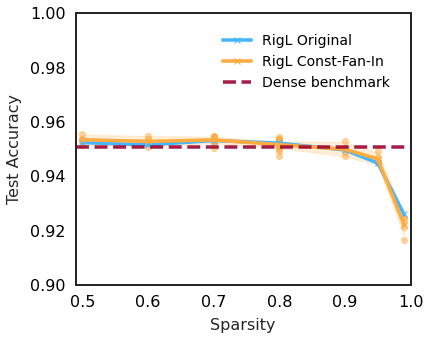

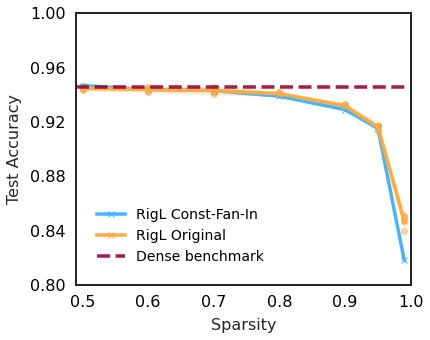

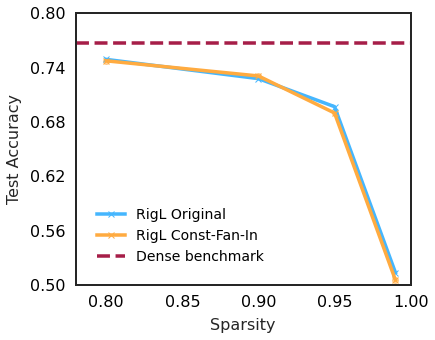

In [71]:
def get_accuracy_vs_sparsity_plot(model_name, ids, dense_benchmark_value, plot_99_sparsity=True, ylim=[0.9,1.0], xlim=[0.49,1.0]):
    _BENCHMARK_VALUE = 0.9506

    plot_df = df.loc[ids].copy().sort_values(by="rigl.dense_allocation")
    plot_df = plot_df.loc[plot_df["state"] == "finished"]
    if not plot_99_sparsity:
      plot_df = plot_df.loc[plot_df["rigl.dense_allocation"] != 0.01]
    plot_df["sparsity"] = 1-plot_df["rigl.dense_allocation"]
    plot_dfs = []
    fig, ax = plt.subplots(figsize=(6,5))
    colors = ['#45b6fe','#ffab40','#9c0534'] # '#ffab40' '#ff671f'


    for idx, fan_in in enumerate(plot_df["rigl.const_fan_in"].unique()):
        df_slice = plot_df.loc[plot_df["rigl.const_fan_in"] == fan_in]
        if fan_in:
            name = "RigL Const-Fan-In"
        else:
            name = "RigL Original"
        agg_results = get_confidence_bounds_df(df_slice)
        # display(agg_results)
        ax.plot(
            agg_results["sparsity"], agg_results["mean"], marker='x', label=name, color=colors[idx], alpha=1.0
        )
    ax.fill_between(
        agg_results["sparsity"],
        agg_results["upper_bound"],
        agg_results["lower_bound"],
        color=colors[idx],
        alpha=0.20
    )
    ax.scatter(
        df_slice["sparsity"], df_slice["accuracy"], marker='o', color=colors[idx], alpha=0.5
    )

    ax.plot(xlim, [dense_benchmark_value, dense_benchmark_value], "--",  label="Dense benchmark", color=colors[2], alpha=0.9)
    model_name_dict = dict(
        resnet18="ResNet18",
        wide_resnet22="WideResNet22"
    )
    #plt.title(f"{model_name_dict[_MODEL]} CIFAR-10 Validation Set Accuracy vs. Sparsity")
    plt.xlabel('Sparsity')
    plt.ylabel('Test Accuracy')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    tick_spaces=5
    y_tick_eps = (max(ylim) - min(ylim))/tick_spaces
    y_ticks = [min(ylim)+y_tick_eps*x for x in range(tick_spaces+1)]
    ax.set_yticks(y_ticks)
    fig_name = f"{model_name}_cifar_results"
    fig.savefig(f"{model_name}.png", dpi=600, bbox_inches="tight")
    fig.savefig(f"{model_name}.svg",format="svg", bbox_inches="tight")
    return fig

resnet18_params=dict(
    ids = resnet_ids,
    model_name ="resnet18",
    dense_benchmark_value = 0.9506,
    plot_99_sparsity=True
)

wide_resnet22_params=dict(
    ids = wide_res_ids,
    model_name ="wide_resnet22",
    dense_benchmark_value = 0.9455,
    plot_99_sparsity=True,
    ylim=[0.8,1.0]
)

imagenet_params=dict(
    ids = imagenet.index.to_list(),
    model_name ="resnet50",
    dense_benchmark_value = 0.7674,
    plot_99_sparsity=True,
    ylim=[0.5,0.8],
    xlim=[0.78,1.0],
)



fig = get_accuracy_vs_sparsity_plot(**resnet18_params)
fig = get_accuracy_vs_sparsity_plot(**wide_resnet22_params)
fig = get_accuracy_vs_sparsity_plot(**imagenet_params)
fig.show()


/home/user/build/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/user/build/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,sparsity,mean,lower_bound,upper_bound
0,0.99,60.874456,NaN,NaN
1,0.95,91.835994,NaN,NaN
2,0.90,97.772134,NaN,NaN
3,0.80,99.132801,NaN,NaN


/home/user/build/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/user/build/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,sparsity,mean,lower_bound,upper_bound
0,0.99,58.835269,NaN,NaN
1,0.95,94.706096,NaN,NaN
2,0.90,98.642961,NaN,NaN
3,0.80,99.437591,NaN,NaN


,sparsity,mean,lower_bound,upper_bound
0,0.99,NaN,NaN,NaN
1,0.95,NaN,NaN,NaN
2,0.90,NaN,NaN,NaN
3,0.80,NaN,NaN,NaN
4,0.70,NaN,NaN,NaN
5,0.60,NaN,NaN,NaN
6,0.50,NaN,NaN,NaN


,sparsity,mean,lower_bound,upper_bound
0,0.99,69.933472,68.116510,71.750434
1,0.95,85.484407,84.220512,86.748303
2,0.90,90.465696,89.194022,91.737371
3,0.80,95.118503,NaN,NaN
4,0.70,96.694387,NaN,NaN
5,0.60,NaN,NaN,NaN
6,0.50,NaN,NaN,NaN


,sparsity,mean,lower_bound,upper_bound
0,0.99,77.214555,74.436163,79.992946
1,0.95,91.982434,91.694113,92.270755
2,0.90,93.801757,93.518746,94.084767
3,0.80,95.085738,NaN,NaN
4,0.70,95.378503,NaN,NaN
5,0.60,95.023003,NaN,NaN
6,0.50,NaN,NaN,NaN


,sparsity,mean,lower_bound,upper_bound
0,0.99,NaN,NaN,NaN
1,0.95,NaN,NaN,NaN
2,0.90,NaN,NaN,NaN
3,0.80,NaN,NaN,NaN
4,0.70,NaN,NaN,NaN
5,0.60,NaN,NaN,NaN
6,0.50,NaN,NaN,NaN


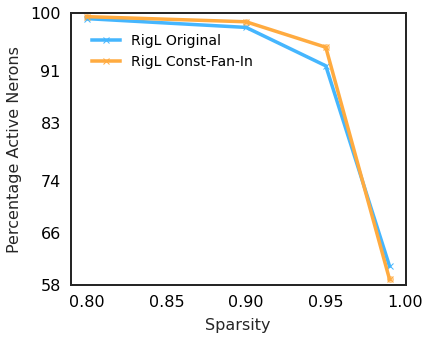

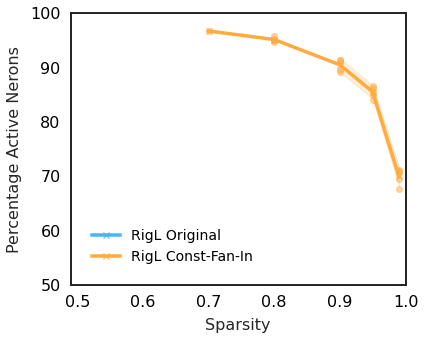

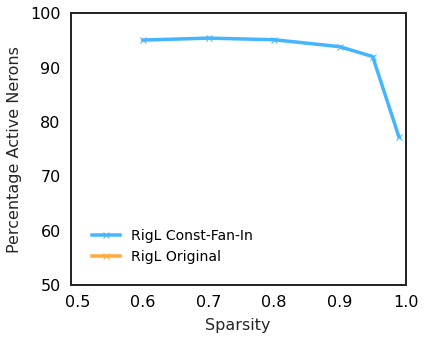

In [80]:
def plot_active_neurons_vs_sparsity(df, model_name="", ylim=[0.9,1.0], xlim=[0.49,1.0]):
    _TARGET_COL="_TOTAL_PERCENTAGE_ACTIVE_NEURONS"
    df=df.copy(deep=True)
    df = df.sort_values(by="rigl.dense_allocation")
    df["sparsity"] = 1-df["rigl.dense_allocation"]
    plot_dfs = []
    fig, ax = plt.subplots(figsize=(6,5))
    colors = ['#45b6fe','#ffab40','#9c0534'] # '#ffab40' '#ff671f'


    for idx, fan_in in enumerate(df["rigl.const_fan_in"].unique()):
        df_slice = df.loc[df["rigl.const_fan_in"] == fan_in]
        if fan_in:
            name = "RigL Const-Fan-In"
        else:
            name = "RigL Original"
        agg_results = get_confidence_bounds_df(df_slice, target_col=_TARGET_COL)
        display(agg_results)
        ax.plot(
            agg_results["sparsity"], agg_results["mean"], marker='x', label=name, color=colors[idx], alpha=1.0
        )
    ax.fill_between(
        agg_results["sparsity"],
        agg_results["upper_bound"],
        agg_results["lower_bound"],
        color=colors[idx],
        alpha=0.20
    )
    ax.scatter(
        df_slice["sparsity"], df_slice[_TARGET_COL], marker='o', color=colors[idx], alpha=0.5
    )

    plt.xlabel('Sparsity')
    plt.ylabel('Percentage Active Nerons')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    tick_spaces=5
    y_tick_eps = (max(ylim) - min(ylim))/tick_spaces
    y_ticks = [int(min(ylim)+y_tick_eps*x) for x in range(tick_spaces+1)]
    ax.set_yticks(y_ticks)
    fig.savefig(f"{model_name}_perc_active.png", dpi=600, bbox_inches="tight")
    fig.savefig(f"{model_name}_perc_active.svg",format="svg", bbox_inches="tight")
    return fig

fig = plot_active_neurons_vs_sparsity(imagenet, "imagenet", ylim=[58, 100], xlim=[0.79, 1.0])
fig = plot_active_neurons_vs_sparsity(df.loc[resnet_ids], "resnet18", ylim=[50, 100])
fig = plot_active_neurons_vs_sparsity(df.loc[wide_res_ids], "wide_resnet22", ylim=[50, 100])


In [123]:

min_salient_sweep_id = "hgqc3joo"
min_sal_df = df.loc[df["sweep_id"]==min_salient_sweep_id]
min_sal_df.groupby(["model", "rigl.dense_allocation", "rigl.min_salient_weights_per_neuron"]).count()

ITOP Rate  \
model         rigl.dense_allocation rigl.min_salient_weights_per_neuron              
resnet18      0.01                  0.000                                        5   
                                    0.001                                        5   
                                    0.005                                        5   
                                    0.010                                        5   
                                    0.050                                        5   
                                    0.100                                        5   
                                    1.000                                        5   
              0.05                  0.000                                        5   
                                    0.001                                        5   
                                    0.005                                        5   
                                    0.010                                        5   
                                    0.050                                        5   
                                    0.100                                        5   
                                    1.000                                        5   
              0.10                  0.000                                        5   
                                    0.001                                        5   
                                    0.005                                        5   
                                    0.010                                        5   
                                    0.050                                        5   
                                    0.100                                        5   
                                    1.000                                        5   
wide_resnet22 0.01                  0.000                                        5   
                                    0.001                                        5   
                                    0.005                                        5   
                                    0.010                                        5   
                                    0.050                                        5   
                                    0.100                                        5   
                                    1.000                                        5   
              0.05                  0.000                                        5   
                                    0.001                                        5   
                                    0.005                                        5   
                                    0.010                                        5   
                                    0.050                                        5   
                                    0.100                                        5   
                                    1.000                                        5   
              0.10                  0.000                                        5   
                                    0.001                                        5   
                                    0.005                                        5   
                                    0.010                                        5   
                                    0.050                                        5   
                                    0.100                                        5   
                                    1.000                                        5   

                                                                         Learning Rate  \
model         rigl.dense_allocation rigl.min_salient_weights_per_neuron                  
resnet18      0.01                  0.000                                            5   
                  

In [132]:
10**0


1

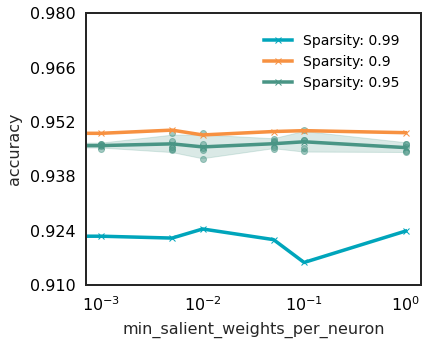

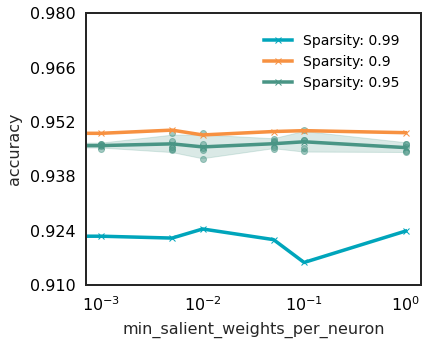

In [129]:
## Hyperparam search for min salient

def plot_min_salient_sweep(df, model_name="", ylim=[0.9,1.0], xlim=[0.49,1.0]):
    _TARGET_COL="accuracy"
    x_col = "rigl.min_salient_weights_per_neuron"
    df=df.copy(deep=True)
    df = df.sort_values(by=x_col)
    df["sparsity"] = 1-df["rigl.dense_allocation"]
    plot_dfs = []
    fig, ax = plt.subplots(figsize=(6,5))
    # colors = ['#45b6fe','#ffab40','#9c0534', '#ffab40', '#ff671f']
    colors = ['#00a5bb','#f79141','#499585', '#d81e52', '#6cb2c5' , '#6c77c5', '#c5ba6c', '#56ce93', '#d88fBf', '#ffd505']


    for idx, sparsity in enumerate(df["sparsity"].unique()):
        name=f"Sparsity: {sparsity}"
        df_slice = df.loc[df["sparsity"] == sparsity]
        agg_results = get_confidence_bounds_df(df_slice, target_col=_TARGET_COL, x_col=x_col)
        ax.plot(
            agg_results[x_col], agg_results["mean"], marker='x', label=name, color=colors[idx], alpha=1.0
        )
    ax.fill_between(
        agg_results[x_col],
        agg_results["upper_bound"],
        agg_results["lower_bound"],
        color=colors[idx],
        alpha=0.20
    )
    ax.scatter(
        df_slice[x_col], df_slice[_TARGET_COL], marker='o', color=colors[idx], alpha=0.5
    )

    plt.xlabel('min_salient_weights_per_neuron')
    plt.ylabel('accuracy')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    ax.set_ylim(ylim)
    # ax.set_xlim(xlim)
    ax.set_xscale("log")
    tick_spaces=5
    y_tick_eps = (max(ylim) - min(ylim))/tick_spaces
    y_ticks = [min(ylim)+y_tick_eps*x for x in range(tick_spaces+1)]
    ax.set_yticks(y_ticks)
    fig.savefig(f"{model_name}_salient_sweep.png", dpi=600, bbox_inches="tight")
    fig.savefig(f"{model_name}_salient_sweep.svg",format="svg", bbox_inches="tight")
    return fig


min_salient_sweep_id = "hgqc3joo"
min_sal_df = df.loc[df["sweep_id"]==min_salient_sweep_id]
# min_sal_df["rigl.min_salient_weights_per_neuron"]
for model_name in ['resnet18', 'wide_resnet22']:
    plot_min_salient_sweep(min_sal_df.loc[min_sal_df["model"]=="resnet18"], model_name="resnet18", ylim=[0.91,0.98], xlim=[0,1])